# Topological optimization of the  ICLR acronym

In this notebook, we show how a topological loss can be use to increase the 'connectedness' of a data set.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np
import pandas as pd

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load and view data

We load and view the data as follows.

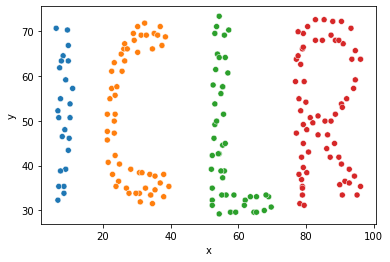

In [2]:
# Load the data
data = pd.read_csv(os.path.join("Data", "ICLR.csv"), delimiter=" ")

# Plot the data
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x", y="y", hue="group", ax=ax)
ax.legend().remove()
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to encourage the model underlying the data to become connected. As a topological loss, we will use the total (finite) 0-dimensional persistence.

In [3]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=0) # alpha complex layer
TotalPersistence = DiagramLoss(dim=0, i=2, g=g) # compute total finite 0-dimensional persistence

# Construct topological loss function
def top_loss(output):
    dgminfo = TopLayer(output)            
    loss = TotalPersistence(dgminfo)
    
    return loss

We can now conduct the topological optimization as follows.

In [4]:
# Dictionary to store optimized point cloud for multiple epochs
optimized = dict()

# Learning hyperparameters
num_epochs = [5, 50, 100, 250, 500, 1000]
learning_rate = 1e0

# Conduct topological optimization
Y = torch.autograd.Variable(torch.tensor(np.array(data.loc[:,["x","y"]])).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

for epoch in range(num_epochs[len(num_epochs) - 1]):
    optimizer.zero_grad()
    loss = top_loss(Y)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs[len(num_epochs) - 1]) / 10) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
    if epoch + 1 in num_epochs:
        optimized[epoch + 1] = Y.detach().numpy().copy()

[epoch 1] [topological loss: 457.542542]
[epoch 100] [topological loss: 129.146744]
[epoch 200] [topological loss: 93.165222]
[epoch 300] [topological loss: 84.318512]
[epoch 400] [topological loss: 78.541626]
[epoch 500] [topological loss: 77.293060]
[epoch 600] [topological loss: 74.688240]
[epoch 700] [topological loss: 69.911301]
[epoch 800] [topological loss: 70.679962]
[epoch 900] [topological loss: 65.238800]
[epoch 1000] [topological loss: 66.778046]


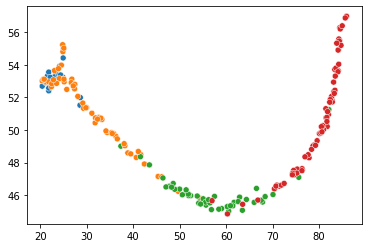

In [5]:
# View topologically optimized data for a particular number of epochs
epoch = 250
fig, ax = plt.subplots()
sns.scatterplot(x=optimized[epoch][:,0], y=optimized[epoch][:,1], hue=data.loc[:,"group"], ax=ax)
ax.legend().remove()
plt.show()

Finally, we save the optimized data sets for plotting in R.

In [6]:
for epoch in num_epochs:
    np.savetxt(os.path.join("Data", "ICLR Optimized" , "epochs" + str(epoch) + ".csv"), 
               optimized[epoch], delimiter=",")